In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression  # Correct import
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


Merged Annual Data:
            Brent Price         GDP
Date                               
2001-12-31        19.35  10400000.0
2002-12-31        30.12  10600000.0
2003-12-31        30.30  10800000.0
2004-12-31        40.38  11000000.0
2007-12-31        93.68  11800000.0


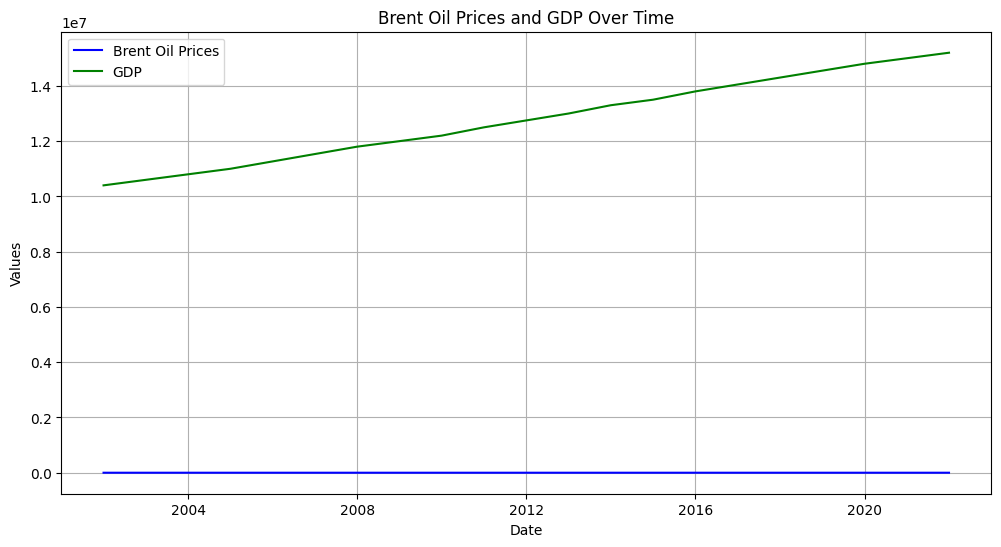

In [18]:
# Load the Brent Oil Prices Dataset
brent_data = pd.read_csv(r'/home/bamw/Downloads/Compressed/data-20241101T120533Z-001/data/Copy of BrentOilPrices.csv')
brent_data['Date'] = pd.to_datetime(brent_data['Date'])
brent_data.set_index('Date', inplace=True)

# Load the GDP Data
gdp_data = pd.read_csv(r'/home/bamw/Downloads/gdp_data.csv')  
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
gdp_data.set_index('Date', inplace=True)

# Resample GDP data to ensure it's annual (if not already)
gdp_data_annual = gdp_data.resample('A').mean()  # Resample to annual frequency

# Now merge with Brent oil prices
data_annual = brent_data.join(gdp_data_annual, how='inner')  
data_annual.columns = ['Brent Price', 'GDP']  

# Check the merged data
print("Merged Annual Data:")
print(data_annual.head())

# Plotting the data
plt.figure(figsize=(12, 6))

# Plot Brent Prices
plt.plot(data_annual.index, data_annual['Brent Price'], label='Brent Oil Prices', color='blue')
# Plot GDP
plt.plot(data_annual.index, data_annual['GDP'], label='GDP', color='green')

plt.title('Brent Oil Prices and GDP Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()


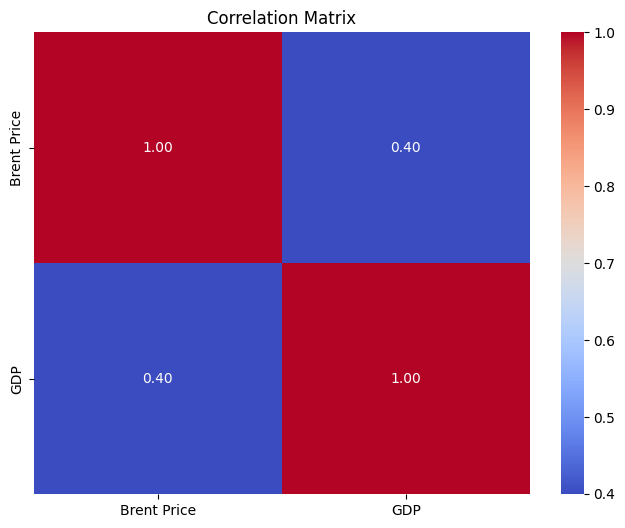

In [20]:
# Correlation Analysis
plt.figure(figsize=(8, 6))
sns.heatmap(data_annual.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [26]:

# Check stationarity
adf_result_brent = adfuller(data_annual['Brent Price'])
adf_result_gdp = adfuller(data_annual['GDP'])

print(f'ADF Statistic for Brent Price: {adf_result_brent[0]}, p-value: {adf_result_brent[1]}')
print(f'ADF Statistic for GDP: {adf_result_gdp[0]}, p-value: {adf_result_gdp[1]}')

# Fit the VAR model with maxlags set to 1
model = VAR(data_annual)
results = model.fit(maxlags=1, ic='aic')
print(results.summary())


ADF Statistic for Brent Price: -2.4903268160642544, p-value: 0.11784569011188845
ADF Statistic for GDP: 1.2326330926180107, p-value: 0.9962037710402181
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Nov, 2024
Time:                     16:27:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    32.0704
Nobs:                     14.0000    HQIC:                   31.7712
Log likelihood:          -256.306    FPE:                6.53025e+13
AIC:                      31.7966    Det(Omega_mle):     4.42882e+13
--------------------------------------------------------------------
Results for equation Brent Price
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 22.242869        67.401201            0.

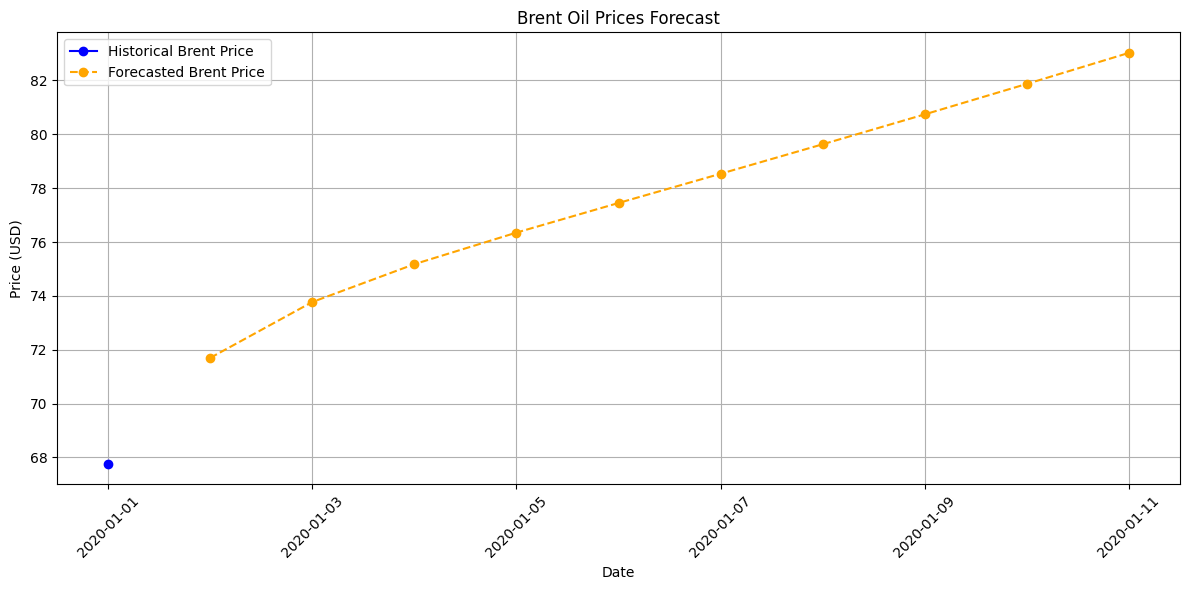

In [ ]:
# Forecasting with VAR
forecast_steps = 10
forecast = results.forecast(data.values[-results.k_ar:], steps=forecast_steps)

# Create a date range for the forecast
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data.columns)

# Plot historical Brent Price and forecasted Brent Price
plt.figure(figsize=(12, 6))
plt.plot(data['Brent Price'], label='Historical Brent Price', color='blue', marker='o')
plt.plot(forecast_df['Brent Price'], label='Forecasted Brent Price', color='orange', linestyle='--', marker='o')
plt.title('Brent Oil Prices Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)  
plt.legend()
plt.grid()
plt.tight_layout()  
plt.show()


In [39]:
# Check the size of the original dataset
print(f"Size of original dataset: {len(data['Brent Price'])}")

# Scale the data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Brent Price'].values.reshape(-1, 1))

# Print the size of the scaled data
print(f"Size of scaled data: {len(scaled_data)}")


Size of original dataset: 1
Size of scaled data: 1


In [ ]:
# Check if the dataset has enough data points for naive forecasting
if len(data['Brent Price']) > 0:
    last_price = data['Brent Price'].values[0]  
    print(f'Naive forecast for the next Brent Price: {last_price}')
else:
    print("Not enough data points for prediction.")


Naive forecast for the next Brent Price: 67.77


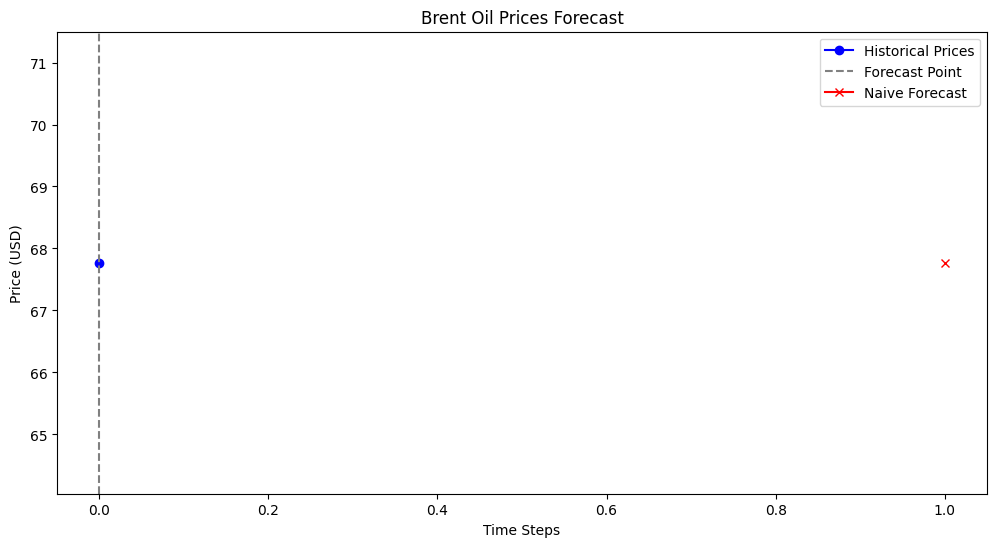

In [ ]:
historical_prices = [67.77]  

# Adding the forecast to the historical prices
forecasted_prices = historical_prices + [67.77]  

plt.figure(figsize=(12, 6))
plt.plot(historical_prices, label='Historical Prices', color='blue', marker='o')
plt.axvline(x=len(historical_prices) - 1, color='gray', linestyle='--', label='Forecast Point')
plt.plot(len(historical_prices), 67.77, label='Naive Forecast', color='red', marker='x')
plt.title('Brent Oil Prices Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
